In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from imutils import paths

import imageio
import cv2
import os

import notebook_utils as utils
from IPython import display
import collections
import time
import numpy as np

import multiprocessing
num_cores = multiprocessing.cpu_count()

from openvino.runtime import Core

In [2]:
decoder = load_model('Models\classifier_lstm_e19.h5', compile=False)
#decoder = load_model('model/my_trained_models/models_for_resnet_encoder/classifier_lstm_e17_for_resnet_encoder.h5', compile=False)

In [3]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 2048)]        0         
                                                                 
 lstm_2 (LSTM)               (None, 32, 256)           2360320   
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 2,561,898
Trainable params: 2,561,898
Non-tra

In [4]:
#Define hyperparameters

IMG_SIZE = (299, 224)
BATCH_SIZE = 30
EPOCHS = 100

MAX_SEQ_LENGTH = 32
NUM_FEATURES = 2048

In [5]:
# Load the network
ie = Core()
model_ir = ie.read_model(model="Models\inceptionv3_model_ir\saved_model.xml")
compiled_model_ir = ie.compile_model(model=model_ir, device_name="CPU")

# Get output layer
output_layer_ir = compiled_model_ir.output(0)

In [6]:
encoder = load_model(r"Models\feature_extractor_inceptionv3.h5")#, compile=False)
#encoder = load_model("model/my_trained_models/models_for_resnet_encoder/encoder_resnet50.h5")#, compile=False)

In [8]:
# Get input size - Encoder.
# height_en, width_en = list(input_key_en.shape)[2:]
try:
    height_en, width_en = list(encoder.inputs[0].shape)[1:3]
except:
    height_en, width_en = list(compiled_model_ir.inputs[0].shape)[1:3]

# Get input size - Decoder.
# frames2decode = list(input_key_de.shape)[0:][1]
frames2decode = list(decoder.inputs[0][1].shape)[0]

In [9]:
# label_processor.get_vocabulary()
class_vocab = ['Abuse', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'Normal', 'RoadAccidents', 'Robbery', 'Shooting']

In [10]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [11]:
def center_crop(frame: np.ndarray) -> np.ndarray:
    """
    Center crop squared the original frame to standardize the input image to the encoder model

    :param frame: input frame
    :returns: center-crop-squared frame
    """
    img_h, img_w, _ = frame.shape
    min_dim = min(img_h, img_w)
    start_x = int((img_w - min_dim) / 2.0)
    start_y = int((img_h - min_dim) / 2.0)
    roi = [start_y, (start_y + min_dim), start_x, (start_x + min_dim)]
    return frame[start_y : (start_y + min_dim), start_x : (start_x + min_dim), ...], roi

def rec_frame_display(frame: np.ndarray, roi) -> np.ndarray:
    """
    Draw a rec frame over actual frame

    :param frame: input frame
    :param roi: Region of interest, image section processed by the Encoder
    :returns: frame with drawed shape

    """

    cv2.line(frame, (roi[2] + 3, roi[0] + 3), (roi[2] + 3, roi[0] + 100), (0, 200, 0), 2)
    cv2.line(frame, (roi[2] + 3, roi[0] + 3), (roi[2] + 100, roi[0] + 3), (0, 200, 0), 2)
    cv2.line(frame, (roi[3] - 3, roi[1] - 3), (roi[3] - 3, roi[1] - 100), (0, 200, 0), 2)
    cv2.line(frame, (roi[3] - 3, roi[1] - 3), (roi[3] - 100, roi[1] - 3), (0, 200, 0), 2)
    cv2.line(frame, (roi[3] - 3, roi[0] + 3), (roi[3] - 3, roi[0] + 100), (0, 200, 0), 2)
    cv2.line(frame, (roi[3] - 3, roi[0] + 3), (roi[3] - 100, roi[0] + 3), (0, 200, 0), 2)
    cv2.line(frame, (roi[2] + 3, roi[1] - 3), (roi[2] + 3, roi[1] - 100), (0, 200, 0), 2)
    cv2.line(frame, (roi[2] + 3, roi[1] - 3), (roi[2] + 100, roi[1] - 3), (0, 200, 0), 2)
    # Write ROI over actual frame
    FONT_STYLE = cv2.FONT_HERSHEY_SIMPLEX
    org = (roi[2] + 3, roi[1] - 3)
    org2 = (roi[2] + 2, roi[1] - 2)
    FONT_SIZE = 0.5
    FONT_COLOR = (0, 200, 0)
    FONT_COLOR2 = (0, 0, 0)
    cv2.putText(frame, "ROI", org2, FONT_STYLE, FONT_SIZE, FONT_COLOR2)
    cv2.putText(frame, "ROI", org, FONT_STYLE, FONT_SIZE, FONT_COLOR)
    return frame

In [12]:
def display_text_fnc_modified(frame, display_text, index):
    # Configuration for displaying images with text.
    FONT_COLOR = (255, 255, 255)
    FONT_COLOR2 = (0, 0, 0)
    FONT_STYLE = cv2.FONT_HERSHEY_DUPLEX
    FONT_SIZE = 0.7
    TEXT_VERTICAL_INTERVAL = 25
    TEXT_LEFT_MARGIN = 15
    
    text_loc = (TEXT_LEFT_MARGIN, TEXT_VERTICAL_INTERVAL * (index + 1))
    text_loc2 = (TEXT_LEFT_MARGIN + 1, TEXT_VERTICAL_INTERVAL * (index + 1) + 1)
    
    # _ = cv2.putText(frame, 'OpenCV', text_loc, cv2.FONT_HERSHEY_DUPLEX, 1,         (255, 0, 0))
    #   # cv2.putText(frame, display_, text_loc, FONT_STYLE,              FONT_SIZE, FONT_COLOR)
    # _ = cv2.putText(frame, display_text, text_loc2, FONT_STYLE, FONT_SIZE, FONT_COLOR2)
    frame2 = frame.copy()
    _ = cv2.putText(frame2, display_text, text_loc, FONT_STYLE, FONT_SIZE, FONT_COLOR)
    # plt.imshow(_)
    return frame2

In [13]:
def display_text_fnc(frame, display_text, index):
    """
    Include a text on the analyzed frame

    :param frame: input frame
    :param display_text: text to add on the frame
    :param index: index line dor adding text

    """
    # Configuration for displaying images with text.
    FONT_COLOR = (255, 255, 255)
    FONT_COLOR2 = (0, 0, 0)
    FONT_STYLE = cv2.FONT_HERSHEY_DUPLEX
    FONT_SIZE = 0.5
    TEXT_VERTICAL_INTERVAL = 25
    TEXT_LEFT_MARGIN = 15
    
    # # ROI over actual frame
    # (processed, roi) = center_crop(frame)
    # # Draw a ROI over actual frame.
    # frame = rec_frame_display(frame, roi)
    
    # Put a text over actual frame.
    text_loc = (TEXT_LEFT_MARGIN, TEXT_VERTICAL_INTERVAL * (index + 1))
    text_loc2 = (TEXT_LEFT_MARGIN + 1, TEXT_VERTICAL_INTERVAL * (index + 1) + 1)
    frame2 = frame.copy()
    _ = cv2.putText(frame2, display_text, text_loc2, FONT_STYLE, FONT_SIZE, FONT_COLOR2)
    _ = cv2.putText(frame2, display_text, text_loc, FONT_STYLE, FONT_SIZE, FONT_COLOR)
    return frame2

In [14]:
frames_idx = []

In [15]:
def run_action_recognition(
    source: str = '0',
    flip: bool = True,
    skip_first_frames: int = 0
):
    ########################
    size = height_en  # Endoder input size
    sample_duration = frames2decode  # Decoder input size
    # Select frames per second of your source.
    fps = 30
    player = None
    ########################
    final_inf_counter = 0
    final_infer_time = time.time()
    final_infer_duration = 0
    #############################################
    global frames_idx
    frame_counter = None
    #############################################
    try:
        
        # Create a video player.
        player = utils.VideoPlayer(source, flip=flip, fps=fps, skip_first_frames=skip_first_frames)
        # Start capturing.
        player.start()
        processing_times = collections.deque()
        processing_time = 0
        encoder_output = []
        decoded_labels = [0, 0, 0]
        decoded_top_probs = [0, 0, 0]
        counter = 0
        # Create a text template to show inference results over video.
        text_inference_template = "Infer Time:{Time:.1f}ms"#,{fps:.1f}FPS"
        text_template = "{label},{conf:.2f}%"
        
        while True:
            
            counter = counter + 1
            # Read a frame from the video stream.
            frame, frame_counter = player.next() ######################################
            
            if frame is None:
                print("Source ended")
                break
            
            #preprocessed = crop_center_square(frame)
            preprocessed = cv2.resize(frame, IMG_SIZE)
            preprocessed = preprocessed[:, :, [2, 1, 0]]    # BGR -> RGB
            
            # Select one frame every two for processing through the encoder.
            # After 16 frames are processed, the decoder will find the action,
            # and the label will be printed over the frames.
            
            ###########################################################################################################
            
            if counter % 2 == 0:
                #############################################
                frames_idx.append((counter, frame_counter, 'Yes'))
                #############################################
            
                # # Preprocess frame before Encoder.
                # (preprocessed, _) = preprocessing(frame, size)

                # Measure processing time.
                start_time = time.time()

                # Encoder Inference per frame
                # encoder_output.append(encoder(frame, compiled_model_en))
                #encoder_output.append(encoder.predict(preprocessed[None, ...]).astype(np.float32)[0])#, workers=num_cores, use_multiprocessing=True)[0])
                encoder_output.append(compiled_model_ir([preprocessed[None, ...]])[output_layer_ir][0])
                
                if len(encoder_output) == sample_duration:
                    # decoded_labels, decoded_top_probs = decoder(encoder_output, compiled_model_de)
                    frame_mask = np.array([[1]*sample_duration])
                    encoder_output = np.array(encoder_output)[None, ...]
                    #probabilities = decoder.predict([encoder_output, frame_mask])[0]#, workers=num_cores, use_multiprocessing=True)[0]
                    probabilities = decoder.predict(encoder_output)[0]
                    for idx, i in enumerate(np.argsort(probabilities)[::-1][:3]):
                        decoded_labels[idx] = class_vocab[i]
                        decoded_top_probs[idx] = probabilities[i]
                    encoder_output = []
                    final_inf_counter += 1
                    final_infer_duration = (time.time() - final_infer_time)
                    final_infer_time = time.time()
                # Inference has finished. Display the results.
                stop_time = time.time()

                # Calculate processing time.
                processing_times.append(stop_time - start_time)

                # Use processing times from last 200 frames.
                if len(processing_times) > 200:
                    processing_times.popleft()

                # Mean processing time [ms]
                processing_time = np.mean(processing_times) * 1000
                fps = 1000 / processing_time
                
            else:
                #############################################
                frames_idx.append((counter, frame_counter, 'No'))
#                 frame = cv2.putText(frame, f"Encoded: No", (30, 300), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
                #############################################
                
            ##################################################################################################
            frame = cv2.resize(frame, (620, 350))
            # Visualize the results.
            for i in range(0, 3):
                display_text = text_template.format(
                    label=decoded_labels[i],
                    conf=decoded_top_probs[i] * 100,
                )
                frame = display_text_fnc(frame, display_text, i)

            display_text = text_inference_template.format(Time=processing_time, fps=fps)
            
            frame = display_text_fnc(frame, display_text, 3)
            
            frame = display_text_fnc(frame, f"Infer Count: {final_inf_counter}",4)# (Time Taken: {final_infer_duration}s)", 4)
            
            # Encode numpy array to jpg.
            _, encoded_img = cv2.imencode(".jpg", frame, params=[cv2.IMWRITE_JPEG_QUALITY, 90])
            # Create an IPython image.
            i = display.Image(data=encoded_img)
            # Display the image in this notebook.
            display.clear_output(wait=True)
            display.display(i)
            #cv2.imwrite()
          
    except KeyboardInterrupt:
        print("Interrupted")
    except RuntimeError as e:    # Any different error
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()

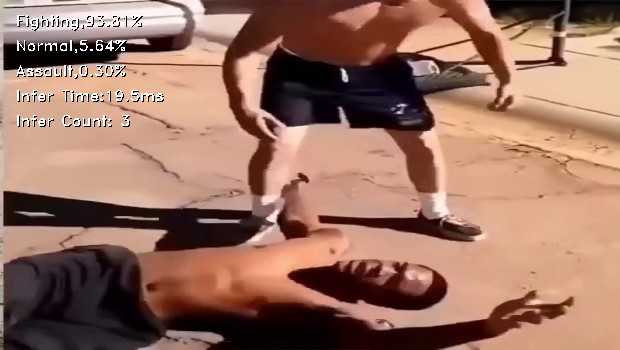

Source ended


In [17]:
try:
	run_action_recognition(source="vid.mp4", flip=False, skip_first_frames=34)
except Exception as e:
    print(e)
    print("Good Bye")